In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

In [59]:
file_path = r"C:\Users\71589\Desktop\News_Category_Dataset_v3.json"
df = pd.read_json(file_path, lines=True)

In [60]:
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [61]:
# Step 2: Clean the Dataset
df = df.dropna(subset=['headline', 'category'])  # Remove rows with missing value

In [62]:
# Extract text (headlines) and labels (categories)
texts = df['headline'].astype(str).values
categories = df['category'].values

In [63]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(categories)

In [64]:
# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)

In [65]:
X.shape

(209527, 5000)

In [66]:
# Step 5: Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    encoded_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=encoded_labels  # Maintain class distribution
)

In [67]:
# Step 7: Build the Model
model = Sequential([
    InputLayer(shape = (X_train.shape[1],)),   # Input layer
    Dense(128, activation='relu'),                 # First GRU layer
    BatchNormalization(),                            # Batch normalization for stable training
    Dropout(0.5),                                    # Dropout for regularization
    Dense(256, activation='relu'),                   # Fully connected dense layer
    Dropout(0.5),                                    # Dropout for regularization
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

In [68]:
# Step 8: Compile the Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    
)


In [69]:
# Step 9: Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

In [70]:
# Step 10: Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,         # Train for up to 10 epochs
    batch_size=64,    # Larger batch size for faster iterations
    #callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 87s 34ms/step - accuracy: 0.3294 - loss: 2.6865 - val_accuracy: 0.5277 - val_loss: 1.7943
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - accuracy: 0.5069 - loss: 1.8704 - val_accuracy: 0.5384 - val_loss: 1.7154
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - accuracy: 0.5351 - loss: 1.7352 - val_accuracy: 0.5463 - val_loss: 1.6795
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.5523 - loss: 1.6494 - val_accuracy: 0.5485 - val_loss: 1.6624
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - accuracy: 0.5611 - loss: 1.5905 - val_accuracy: 0.5473 - val_loss: 1.6617
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - accuracy: 0.5702 - loss: 1.5408 - val_accuracy: 0.5523 - val_loss: 1.6523
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 68s 32ms/step - accuracy: 0.5816 - loss: 1.4977 - val_accuracy: 0.5506 - val_loss: 1.6559
Epoch 8/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 72s 34ms/step - accuracy: 0.5891 -

In [57]:
X_train

<167621x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1321018 stored elements in Compressed Sparse Row format>

In [74]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5527 - loss: 1.6615
Test Accuracy: 0.55


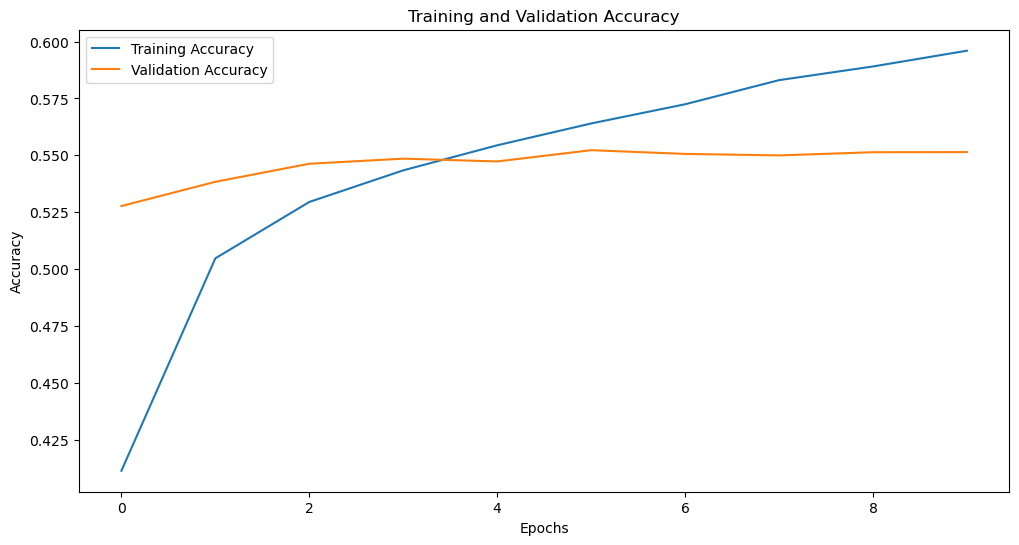

In [75]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()